# Resources

* This notebook is for the blog post [Four Oversampling and Under-Sampling Methods for Imbalanced Classification Using Python](https://medium.com/grabngoinfo/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037)
* Video tutorial on [YouTube](https://www.youtube.com/watch?v=kZNkaNATmd8&list=PLVppujud2yJo0qnXjWVAa8h7fxbFJHtfJ&index=1)
* More video tutorials on [imbalanced modeling and anomaly detection](https://www.youtube.com/playlist?list=PLVppujud2yJo0qnXjWVAa8h7fxbFJHtfJ)
* More blog posts on [imbalanced modeling and anomaly detection](https://medium.com/@AmyGrabNGoInfo/list/databricks-and-pyspark-7b59768e202d)


For more information about data science and machine learning, please check out my [YouTube channel](https://www.youtube.com/channel/UCmbA7XB6Wb7bLwJw9ARPcYg), [Medium Page](https://medium.com/@AmyGrabNGoInfo) and [GrabNGoInfo.com](https://grabngoinfo.com/tutorials/), or follow GrabNGoInfo on [LinkedIn](https://www.linkedin.com/company/grabngoinfo/).

#Intro

Oversampling and under-sampling are the techniques to change the ratio of the classes in an imbalanced modeling dataset. This step-by-step tutorial explains how to use oversampling and under-sampling in the Python `imblearn` library to adjust the imbalanced classes for machine learning models. We will compare the following four methods with the baseline random forest model results:
* Random Oversampling
* SMOTE (Synthetic Minority Oversampling Technique) Oversampling
* Random Under-Sampling
* Near Miss Under-Sampling

First off, what is imbalance classification? Imbalance classification is also called rare event modeling. When the target label for a classification modeling dataset is highly imbalanced, we call the minority event to be a rare event. In this case, the model tends to get learnings from the majority class, and predicting the minority class can be challenging. For example, if only 0.01% of the dataset is the minority event, the model tends not to do a good job identifying the pattern of the minority event.

Rare event modeling for imbalanced datasets has many use cases. Fraud event detection, severe disease diagnosis, and credit card invitation response are some examples.

Let's get started!

# Step 1: Install And Import Libraries

We will use a library called imbalanced-learn to handle imbalanced datasets, so let's install the library first.

In [ ]:
pip install -U imbalanced-learn

     |████████████████████████████████| 206 kB 5.1 MB/s 
     |████████████████████████████████| 22.3 MB 33 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


Now let's import the Python libraries.

In [ ]:
# Creating the modeling dataset
from sklearn.datasets import make_classification

# Data processing
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model and performance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Over sampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

# Step 2: Create Imbalanced Dataset

Using `make_classification` from the sklearn library, we created an imbalanced dataset with two classes. The minority class is 0.5% of the dataset. I made two features to predict which type each data point belongs to.

In [ ]:
# Create an imbalanced dataset
X, y = make_classification(n_samples=100000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.995, 0.005],
                           class_sep=0.5, random_state=0)

# Convert the data from numpy array to a pandas dataframe
df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1], 'target': y})

# Check the target distribution
df['target'].value_counts(normalize = True)

0    0.9897
1    0.0103
Name: target, dtype: float64

The dataset gives us around 1% data points for the minority class. It is higher than the specified weights of 0.5% but works for demonstrating the rare event modeling process.

In [ ]:
# Check the count of each class
df['target'].value_counts()

0    98970
1     1030
Name: target, dtype: int64

In [ ]:
df.head()

,feature1,feature2,target
0,1.236497,0.579272,0
1,-0.188720,-0.022001,0
2,-0.653844,0.794309,0
3,0.005572,0.593370,0
4,0.482573,0.796902,0


Let's visualize the data using a scatter plot.

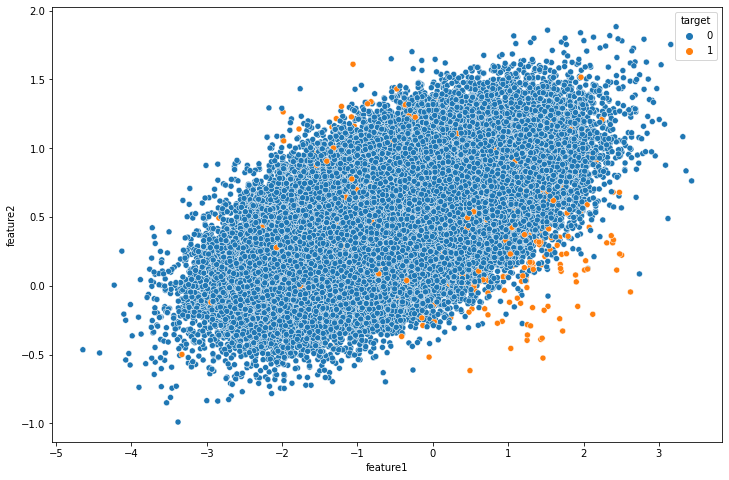

In [ ]:
# Visualize the data
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'feature1', y = 'feature2', hue = 'target', data = df)

# Step 3: Train Test Split

In this step, we split the dataset into 80% training data and 20% validation data. `random_state` ensures that we have the same train test split every time. The seed number for `random_state` does not have to be 42, and it can be any number.

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])

The number of records in the training dataset is 80000
The number of records in the test dataset is 20000


The train test split gives us 80,000 records for the training dataset and 20,000 for the validation dataset. Thus, we have 79,183 data points from the majority class and 817 from the minority class in the training dataset.

In [ ]:
# Check the number of majority and minority classes for the training dataset
print(sorted(Counter(y_train).items()))

[(0, 79183), (1, 817)]


# Step 4: Decide the Performance Metric

Before building the model, we need to decide the performance metric we would like to optimize towards.

The most critical performance metric for the rare events modeling is usually the minority class recall or precision values.
For example, in the context of fraud detection, we would like to maximize the true positive rate and capture as many fraud cases as possible, so recall for the minority class is the metric we would like to optimize.

While in the context of spam email classification, we would like to minimize the false positive rate and not misclassify any important email as spam, so the precision for the minority class is the metric we would like to optimize.

In this tutorial, we use fraud detection as an example and choose recall for the minority class as the metric to optimize.

# Step 5: Baseline Model

We first check the model performance using the imbalanced data directly. A model without oversampling or under-sampling gives us a baseline to compare the model performance. A random forest model is used as an example here.

In [ ]:
# Train the random forest model
rf = RandomForestClassifier()
baseline_model = rf.fit(X_train, y_train)
baseline_prediction = baseline_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, baseline_prediction))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19787
           1       0.50      0.03      0.06       213

    accuracy                           0.99     20000
   macro avg       0.74      0.52      0.53     20000
weighted avg       0.98      0.99      0.98     20000



The recall value ranges from 0 to 1, 0 represents 0% true positive rate, and 1 represents 100% true positive rate. The output shows that the minority class has a recall of 0.03, which is very low.

# Step 6: Random Over Sampling

One way of oversampling is to generate new samples for the minority class by sampling with replacement. The `RandomOverSampler` from the `imblearn` library provides such functionality.
Note that we apply the oversampling technique to the training dataset only. The testing dataset needs to keep untouched.

In [ ]:
# Randomly over sample the minority class
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

# Check the number of records after over sampling
print(sorted(Counter(y_train_ros).items()))

[(0, 79183), (1, 79183)]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After random oversampling, the minority category increased from 817 to 79183, which is the same as the majority category.

From the visualization, we can see more orange minority data points after random oversampling.

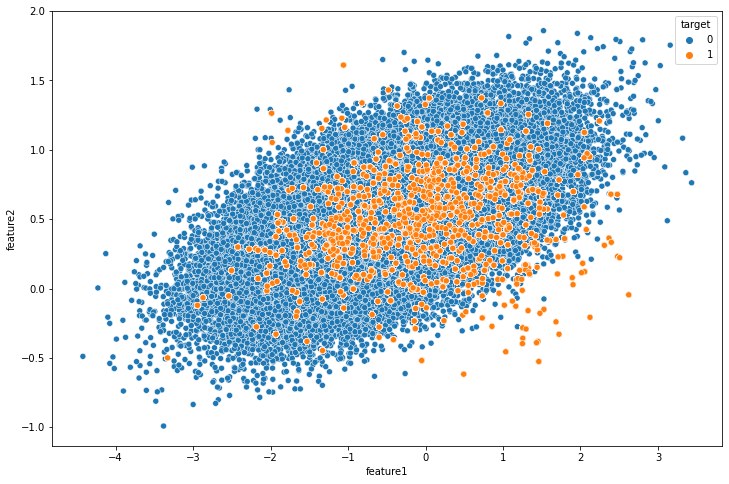

In [ ]:
# Convert the data from numpy array to a pandas dataframe
df_ros = pd.DataFrame({'feature1': X_train_ros[:, 0], 'feature2': X_train_ros[:, 1], 'target': y_train_ros})

# Plot the chart
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'feature1', y = 'feature2', hue = 'target', data = df_ros)
plt.title('Random Over Sampling')

Now let's run the same random forest model and check the performance after random oversampling.

In [ ]:
# Train the random forest model
# rf = RandomForestClassifier()
ros_model = rf.fit(X_train_ros, y_train_ros)
ros_prediction = ros_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, ros_prediction))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19787
           1       0.17      0.03      0.05       213

    accuracy                           0.99     20000
   macro avg       0.58      0.52      0.52     20000
weighted avg       0.98      0.99      0.98     20000



We can see that random oversampling did not provide a better result. We get the same recall and the similar f1-score, and the precision decreased. Thus, the random oversampling has worse performance than the baseline model with no class ratio adjustment.

# Step 7: SMOTE Oversampling

Let's try SMOTE (Synthetic Minority Oversampling Technique), published in 2002 by Chawla, Bowyer, Hall & Kegelmeyer [2]. Instead of randomly oversampling with replacement, SMOTE takes each minority sample and introduces synthetic data points connecting the minority sample and its nearest neighbors. Neighbors from the k nearest neighbors are chosen randomly.

In [ ]:
# Randomly over sample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote= smote.fit_resample(X_train, y_train)

# Check the number of records after over sampling
print(sorted(Counter(y_train_smote).items()))

[(0, 79183), (1, 79183)]


Similar to random oversampling, the minority category increased from 817 to 79183 after SMOTE oversampling.

Comparing the graph between random oversampling and SMOTE, we can see that the synthetic data points created by SMOTE are all along a line.

Text(0.5, 1.0, 'SMOTE Over Sampling')

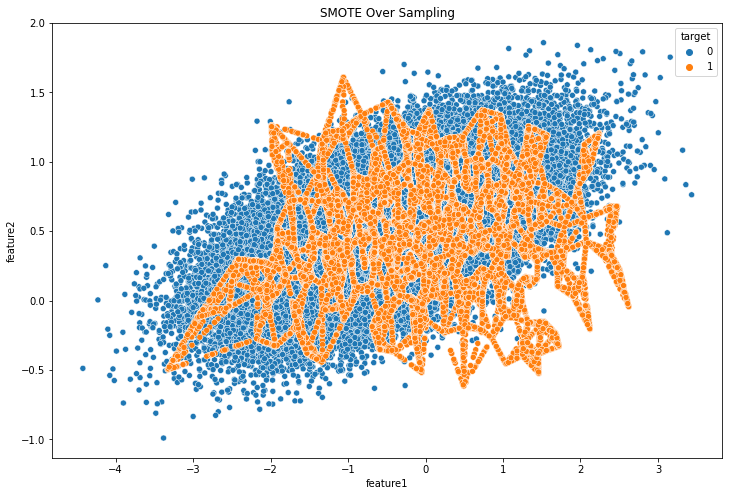

In [ ]:
# Convert the data from numpy array to a pandas dataframe
df_smote = pd.DataFrame({'feature1': X_train_smote[:, 0], 'feature2': X_train_smote[:, 1], 'target': y_train_smote})

# Plot the chart
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'feature1', y = 'feature2', hue = 'target', data = df_smote)
plt.title('SMOTE Over Sampling')



Now let's run the same random forest model on the SMOTE dataset and check it's performance.

In [ ]:
# Train the random forest model
# rf = RandomForestClassifier()
smote_model = rf.fit(X_train_smote, y_train_smote)
smote_prediction = smote_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, smote_prediction))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     19787
           1       0.02      0.24      0.03       213

    accuracy                           0.83     20000
   macro avg       0.50      0.54      0.47     20000
weighted avg       0.98      0.83      0.90     20000



We can see that the model using SMOTE increased recall from 0.03 to 0.24. Thus, it significantly improved the model's ability to capture the minority class.

# Step 8: Random Under-Samplling

Random under-sampling randomly picks data points from the majority class. After the sampling, the majority class has the same number of data points as the minority class.

In [ ]:
# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)

# Check the number of records after under sampling
print(sorted(Counter(y_train_rus).items()))

[(0, 817), (1, 817)]


After random under-sampling, the majority category decreased from 79183 to 817, which is the same as the minority category.

The visualization shows that we have less data points for the model.

Text(0.5, 1.0, 'Random Under Sampling')

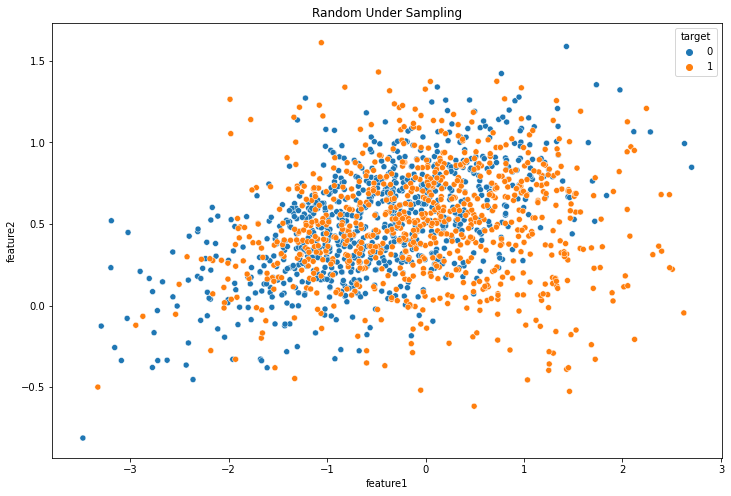

In [ ]:
# Convert the data from numpy array to a pandas dataframe
df_rus = pd.DataFrame({'feature1': X_train_rus[:, 0], 'feature2': X_train_rus[:, 1], 'target': y_train_rus})

# Plot the chart
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'feature1', y = 'feature2', hue = 'target', data = df_rus)
plt.title('Random Under Sampling')

In [ ]:
# Train the random forest model
# rf = RandomForestClassifier()
rus_model = rf.fit(X_train_rus, y_train_rus)
rus_prediction = rus_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, rus_prediction))

              precision    recall  f1-score   support

           0       0.99      0.60      0.75     19787
           1       0.01      0.50      0.03       213

    accuracy                           0.60     20000
   macro avg       0.50      0.55      0.39     20000
weighted avg       0.98      0.60      0.74     20000



After randomly sampling, the recall increased to 0.50, and it's better than the over sampling results.

# Step 9: Under Sampling Using NearMiss

`NearMiss` from the `imblearn` library uses the KNN (K Nearest Neighbors) to do under sampling.

There are three versions of `NearMiss` algorithms. Based on the documentation of the `imblearn` library, here are the differences of the three versions:
* "NearMiss-1 selects the positive samples for which the average distance to the N closest samples of the negative class is the smallest."
* "NearMiss-2 selects the positive samples for which the average distance to the N farthest samples of the negative class is the smallest."
* "NearMiss-3 is a 2-steps algorithm. First, for each negative sample, their M nearest-neighbors will be kept. Then, the positive samples selected are the one for which the average distance to the N nearest-neighbors is the largest."

This tutorial uses version 3, but you are encouraged to try other versions and compare the performances.

In [ ]:
# Under sample the majority class
nearmiss = NearMiss(version=3)
X_train_nearmiss, y_train_nearmiss= nearmiss.fit_resample(X_train, y_train)

# Check the number of records after over sampling
print(sorted(Counter(y_train_nearmiss).items()))

[(0, 817), (1, 817)]


The visualization shows the pattern of the NearMiss under-sampling.

Text(0.5, 1.0, 'NearMiss Under Sampling')

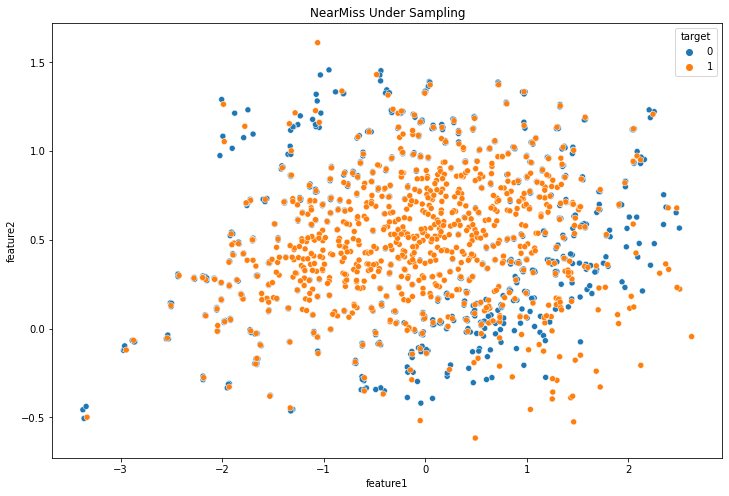

In [ ]:
# Convert the data from numpy array to a pandas dataframe
df_nearmiss = pd.DataFrame({'feature1': X_train_nearmiss[:, 0], 'feature2': X_train_nearmiss[:, 1], 'target': y_train_nearmiss})

# Plot the chart
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'feature1', y = 'feature2', hue = 'target', data = df_nearmiss)
plt.title('NearMiss Under Sampling')

In [ ]:
# Train the random forest model
# rf = RandomForestClassifier()
nearmiss_model = rf.fit(X_train_nearmiss, y_train_nearmiss)
nearmiss_prediction = nearmiss_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, nearmiss_prediction))

              precision    recall  f1-score   support

           0       0.99      0.38      0.55     19787
           1       0.01      0.57      0.02       213

    accuracy                           0.38     20000
   macro avg       0.50      0.48      0.28     20000
weighted avg       0.98      0.38      0.54     20000



`NearMiss` gives us the recall values of 0.57, which is the highest among the four methods.

# Step 10: Put All Code Together

In [ ]:
###### Step 1: Import Libraries

# Creating the modeling dataset
from sklearn.datasets import make_classification

# Data processing
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model and performance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Over sampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

###### Step 2: Create Imbalanced Dataset

# Create an imbalanced dataset
X, y = make_classification(n_samples=100000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.995, 0.005],
                           class_sep=0.5, random_state=0)

# Convert the data from numpy array to a pandas dataframe
df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1], 'target': y})

# Check the target distribution
df['target'].value_counts(normalize = True)

# Check the count of each class
df['target'].value_counts()

# Visualize the data
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'feature1', y = 'feature2', hue = 'target', data = df)

###### Step 3: Train Test Split

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])

# Check the number of majority and minority classes for the training dataset
print(sorted(Counter(y_train).items()))

###### Step 4: Decide the Performance Metric (No code)

###### Step 5: Baseline Model

# Train the random forest model
rf = RandomForestClassifier()
baseline_model = rf.fit(X_train, y_train)
baseline_prediction = baseline_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, baseline_prediction))

###### Step 6: Random Over Sampling

# Randomly over sample the minority class
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

# Check the number of records after over sampling
print(sorted(Counter(y_train_ros).items()))

# Convert the data from numpy array to a pandas dataframe
df_ros = pd.DataFrame({'feature1': X_train_ros[:, 0], 'feature2': X_train_ros[:, 1], 'target': y_train_ros})

# Plot the chart
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'feature1', y = 'feature2', hue = 'target', data = df_ros)
plt.title('Random Over Sampling')

# Train the random forest model
# rf = RandomForestClassifier()
ros_model = rf.fit(X_train_ros, y_train_ros)
ros_prediction = ros_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, ros_prediction))

###### Step 7: SMOTE Over Sampling

# Randomly over sample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote= smote.fit_resample(X_train, y_train)

# Check the number of records after over sampling
print(sorted(Counter(y_train_smote).items()))

# Convert the data from numpy array to a pandas dataframe
df_smote = pd.DataFrame({'feature1': X_train_smote[:, 0], 'feature2': X_train_smote[:, 1], 'target': y_train_smote})

# Plot the chart
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'feature1', y = 'feature2', hue = 'target', data = df_smote)
plt.title('SMOTE Over Sampling')

# Train the random forest model
# rf = RandomForestClassifier()
smote_model = rf.fit(X_train_smote, y_train_smote)
smote_prediction = smote_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, smote_prediction))

###### Step 8: Random Under Samplling

# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)

# Check the number of records after under sampling
print(sorted(Counter(y_train_rus).items()))

# Convert the data from numpy array to a pandas dataframe
df_rus = pd.DataFrame({'feature1': X_train_rus[:, 0], 'feature2': X_train_rus[:, 1], 'target': y_train_rus})

# Plot the chart
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'feature1', y = 'feature2', hue = 'target', data = df_rus)
plt.title('Random Under Sampling')

# Train the random forest model
# rf = RandomForestClassifier()
rus_model = rf.fit(X_train_rus, y_train_rus)
rus_prediction = rus_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, rus_prediction))

###### Step 9: Under Sampling Using NearMiss

# Under sample the majority class
nearmiss = NearMiss(version=3)
X_train_nearmiss, y_train_nearmiss= nearmiss.fit_resample(X_train, y_train)

# Check the number of records after over sampling
print(sorted(Counter(y_train_nearmiss).items()))

# Convert the data from numpy array to a pandas dataframe
df_nearmiss = pd.DataFrame({'feature1': X_train_nearmiss[:, 0], 'feature2': X_train_nearmiss[:, 1], 'target': y_train_nearmiss})

# Plot the chart
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'feature1', y = 'feature2', hue = 'target', data = df_nearmiss)
plt.title('NearMiss Under Sampling')

# Train the random forest model
# rf = RandomForestClassifier()
nearmiss_model = rf.fit(X_train_nearmiss, y_train_nearmiss)
nearmiss_prediction = nearmiss_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, nearmiss_prediction))

# Summary

<!-- wp:paragraph -->
<p>In this tutorial, we talked about how to use oversampling and under-sampling techniques in imbalanced classification models. You have learned</p>
<!-- /wp:paragraph -->

<!-- wp:list -->
<ul><li>What is imbalanced classification</li><li>How to decide the model performance metrics</li><li>How to do oversampling using random oversampling and SMOTE</li><li>How to do under-sampling using random under-sampling and Near Miss</li><li>How to compare the performance of oversampling and under-sampling</li></ul>
<!-- /wp:list -->

# Recommended Tutorials

- [GrabNGoInfo Machine Learning Tutorials Inventory](https://medium.com/grabngoinfo/grabngoinfo-machine-learning-tutorials-inventory-9b9d78ebdd67)
- [Hierarchical Topic Model for Airbnb Reviews](https://medium.com/p/hierarchical-topic-model-for-airbnb-reviews-f772eaa30434)
- [3 Ways for Multiple Time Series Forecasting Using Prophet in Python](https://medium.com/p/3-ways-for-multiple-time-series-forecasting-using-prophet-in-python-7a0709a117f9)
- [Time Series Anomaly Detection Using Prophet in Python](https://medium.com/grabngoinfo/time-series-anomaly-detection-using-prophet-in-python-877d2b7b14b4)
- [Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/time-series-causal-impact-analysis-in-python-63eacb1df5cc)
- [Hyperparameter Tuning For XGBoost](https://medium.com/p/hyperparameter-tuning-for-xgboost-91449869c57e)
- [Four Oversampling And Under-Sampling Methods For Imbalanced Classification Using Python](https://medium.com/p/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037)
- [Five Ways To Create Tables In Databricks](https://medium.com/grabngoinfo/five-ways-to-create-tables-in-databricks-cd3847cfc3aa)
- [Explainable S-Learner Uplift Model Using Python Package CausalML](https://medium.com/grabngoinfo/explainable-s-learner-uplift-model-using-python-package-causalml-a3c2bed3497c)
- [One-Class SVM For Anomaly Detection](https://medium.com/p/one-class-svm-for-anomaly-detection-6c97fdd6d8af)
- [Recommendation System: Item-Based Collaborative Filtering](https://medium.com/grabngoinfo/recommendation-system-item-based-collaborative-filtering-f5078504996a)
- [Hyperparameter Tuning for Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-for-time-series-causal-impact-analysis-in-python-c8f7246c4d22)
- [Hyperparameter Tuning and Regularization for Time Series Model Using Prophet in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc)
- [Multivariate Time Series Forecasting with Seasonality and Holiday Effect Using Prophet in Python](https://medium.com/p/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57)
- [LASSO (L1) Vs Ridge (L2) Vs Elastic Net Regularization For Classification Model](https://medium.com/towards-artificial-intelligence/lasso-l1-vs-ridge-l2-vs-elastic-net-regularization-for-classification-model-409c3d86f6e9)
- [S Learner Uplift Model for Individual Treatment Effect and Customer Segmentation in Python](https://medium.com/grabngoinfo/s-learner-uplift-model-for-individual-treatment-effect-and-customer-segmentation-in-python-9d410746e122)
- [How to Use R with Google Colab Notebook](https://medium.com/p/how-to-use-r-with-google-colab-notebook-610c3a2f0eab)

# References

* [1] [imbalanced learn documentation](https://imbalanced-learn.org/stable/install.html)
* [2] [SMOTE: Synthetic Minority Over-sampling Technique](https://arxiv.org/abs/1106.1813)
* [3] [NearMiss](https://www.scirp.org/(S(351jmbntvnsjt1aadkposzje))/reference/ReferencesPapers.aspx?ReferenceID=1603053)